In [116]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import math

In [117]:
def approx_contours(contours, epsilon_factor=0.02):
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

def remove_nested_rectangles(rectangles):
    non_nested = []
    for rect in rectangles:
        x1, y1, w1, h1 = rect
        nested = False
        for other_rect in rectangles:
            if other_rect == rect:
                continue
            x2, y2, w2, h2 = other_rect
            if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                nested = True
                break
        if not nested:
            non_nested.append(rect)
    return non_nested

def merge_rectangles(rectangles, distance_threshold):
    merged = []
    while rectangles:
        a = rectangles.pop(0)
        to_merge = [a]
        i = 0
        while i < len(rectangles):
            b = rectangles[i]
            if is_close(a, b, distance_threshold):
                to_merge.append(b)
                rectangles.pop(i)
            else:
                i += 1
        xs = [x for x, _, w, _ in to_merge for x in [x, x+w]]
        ys = [y for _, y, _, h in to_merge for y in [y, y+h]]
        merged.append((min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)))
    return merged

def is_close(rect1, rect2, threshold):
    """
    Check if two rectangles are close to each other based on a threshold.
    """
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    distance = np.hypot(center1[0] - center2[0], center1[1] - center2[1])
    return distance < threshold

def merge_contours(contours, threshold=10):
    """
    Merge contours that are close to each other.
    """
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    merged_contours = []

    for i, (x1, y1, w1, h1) in enumerate(bounding_rects):
        if not any(i in c for c in merged_contours):
            merged = [i]
            for j, (x2, y2, w2, h2) in enumerate(bounding_rects):
                if i != j and (abs(x1 - x2) <= threshold and abs(y1 - y2) <= threshold):
                    merged.append(j)
            merged_contours.append(merged)

    # Combine the contours in each group
    final_contours = []
    for group in merged_contours:
        merged_points = [contours[i] for i in group]
        merged_contour = np.vstack(merged_points)
        final_contours.append(merged_contour)

    return final_contours

def apply_contour_symmetry(contour, image_shape):
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Only proceed if the contour is more than a single point
    if contour.shape[0] > 1:
        # Create a blank canvas for the symmetric image
        symmetric_image = np.zeros(image_shape, dtype=np.uint8)

        # Adjust contour to a local coordinate system centered at the bounding box
        adjusted_contour = contour - [x, y]

        # Reflect contour across the vertical axis
        reflected_contour_vertical = np.array([[w - p[0][0], p[0][1]] for p in adjusted_contour])
        reflected_contour_vertical += [x, y]  # Adjust back to global coordinates

        # Reflect contour across the horizontal axis
        reflected_contour_horizontal = np.array([[p[0][0], h - p[0][1]] for p in adjusted_contour])
        reflected_contour_horizontal += [x, y]  # Adjust back to global coordinates

        # Draw the original, vertically reflected, and horizontally reflected contours
        cv2.drawContours(symmetric_image, [contour, reflected_contour_vertical, reflected_contour_horizontal], -1, (255), thickness=cv2.FILLED)
        return symmetric_image
    else:
        # If the contour is a single point, simply return an empty canvas
        return np.zeros(image_shape, dtype=np.uint8)
    
def smooth_contours(contours, alpha=0.02):
    # alpha parameter controls the approximation accuracy
    smoothed_contours = [cv2.approxPolyDP(cnt, alpha * cv2.arcLength(cnt, True), True) for cnt in contours]
    return smoothed_contours


Image: 1040.png, GPR: 1.4, Simplified GPR: 1.4, Storeys:5,  Site area: 23065.1, Building pixels: 4990, Mask pixels: 16203, Generated GPR: 1.5398383015490957


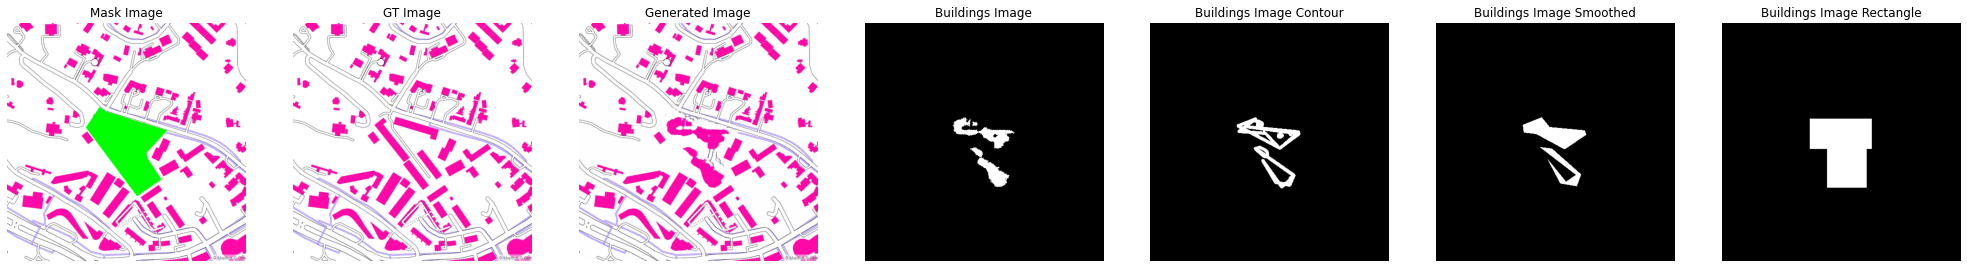

Image: 1074.png, GPR: 2.5, Simplified GPR: 2.8, Storeys:12,  Site area: 37265.0, Building pixels: 3559, Mask pixels: 27286, Generated GPR: 1.5651982701751814


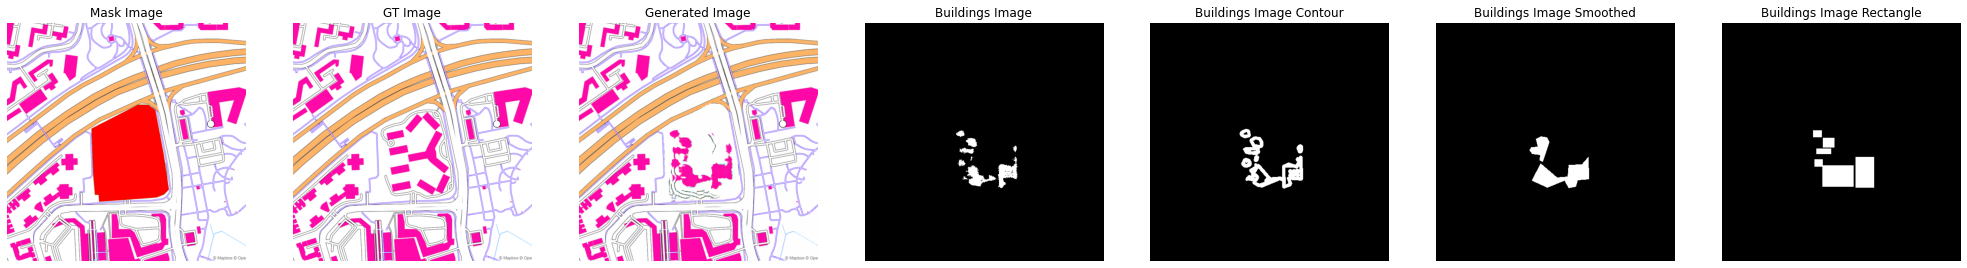

Image: 1076.png, GPR: 2.8, Simplified GPR: 2.8, Storeys:36,  Site area: 10414.2, Building pixels: 1021, Mask pixels: 8468, Generated GPR: 4.340576287198867


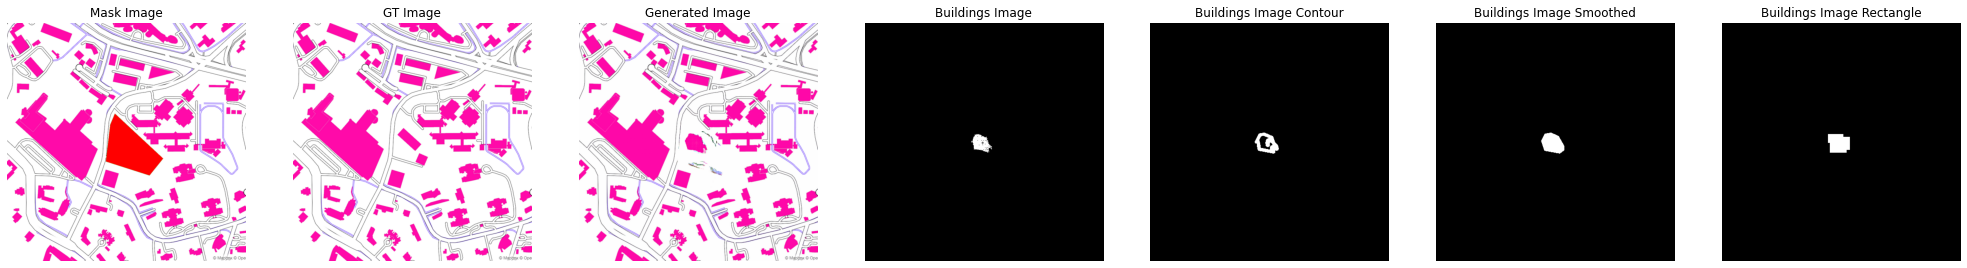

Image: 1102.png, GPR: 1.6, Simplified GPR: 1.6, Storeys:12,  Site area: 6157.3, Building pixels: 1631, Mask pixels: 4749, Generated GPR: 4.121288692356286


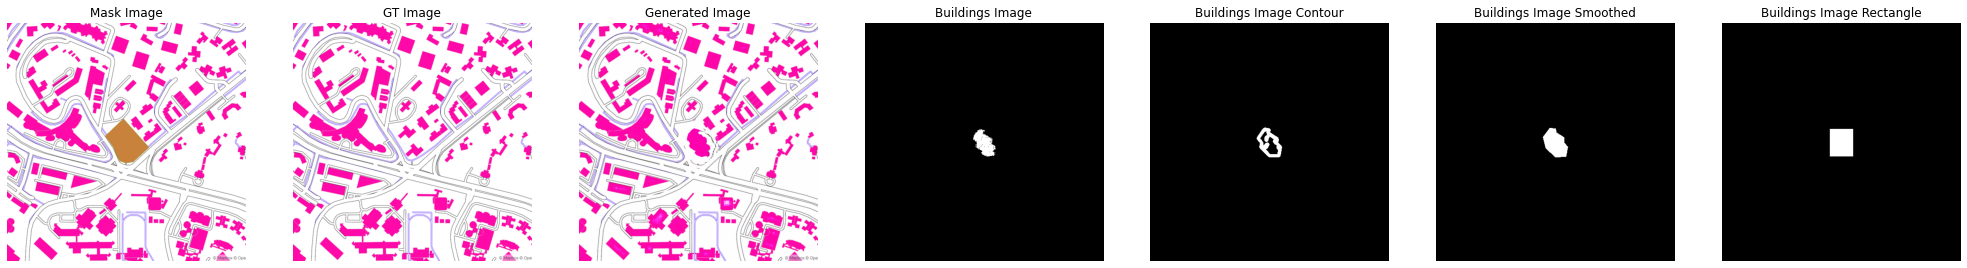

Image: 1180.png, GPR: 3.0, Simplified GPR: 3.0, Storeys:15,  Site area: 19547.0, Building pixels: 2102, Mask pixels: 14230, Generated GPR: 2.2157413914265636


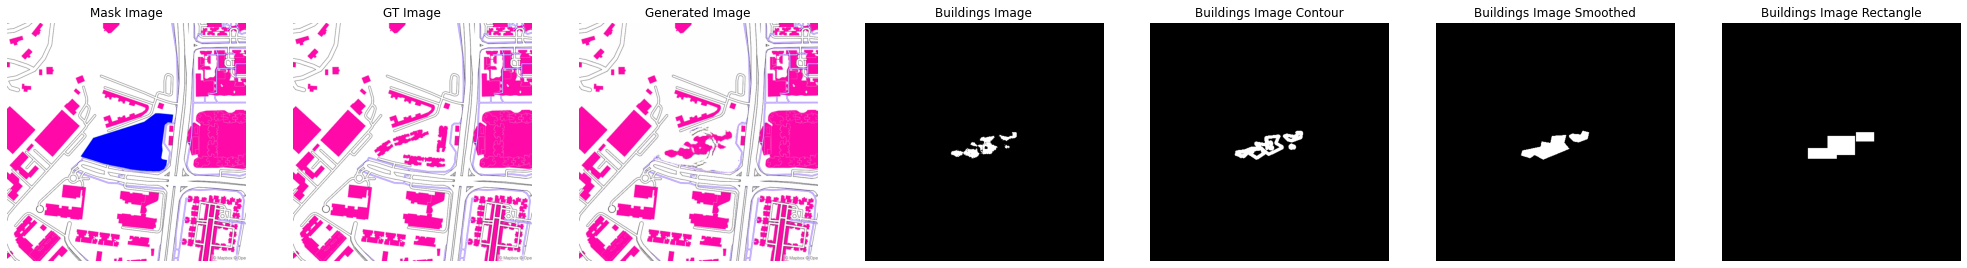

Image: 1379.png, GPR: 1.4, Simplified GPR: 1.4, Storeys:5,  Site area: 17455.9, Building pixels: 4610, Mask pixels: 12216, Generated GPR: 1.8868696791093647


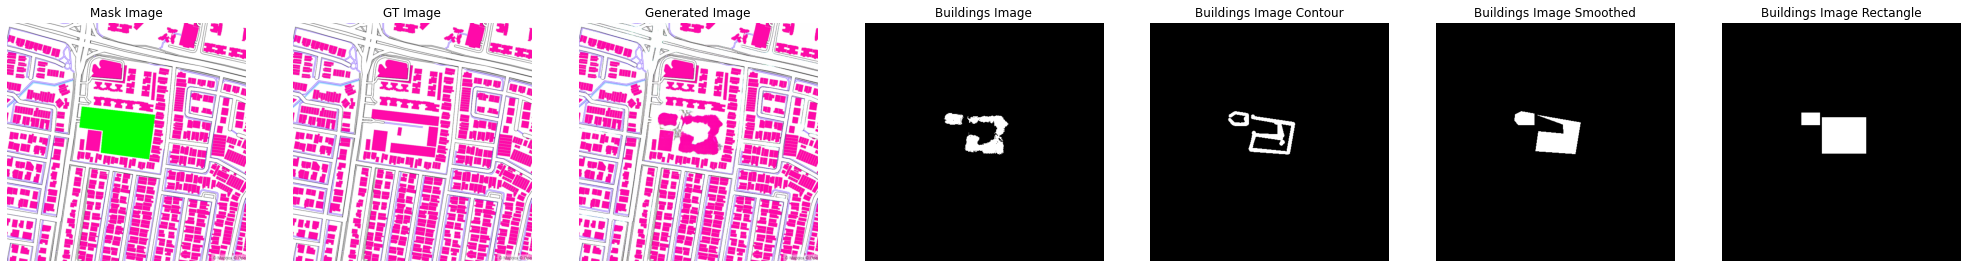

Image: 145.png, GPR: 2.8, Simplified GPR: 2.8, Storeys:15,  Site area: 22094.4, Building pixels: 2196, Mask pixels: 16171, Generated GPR: 2.0369797786160415


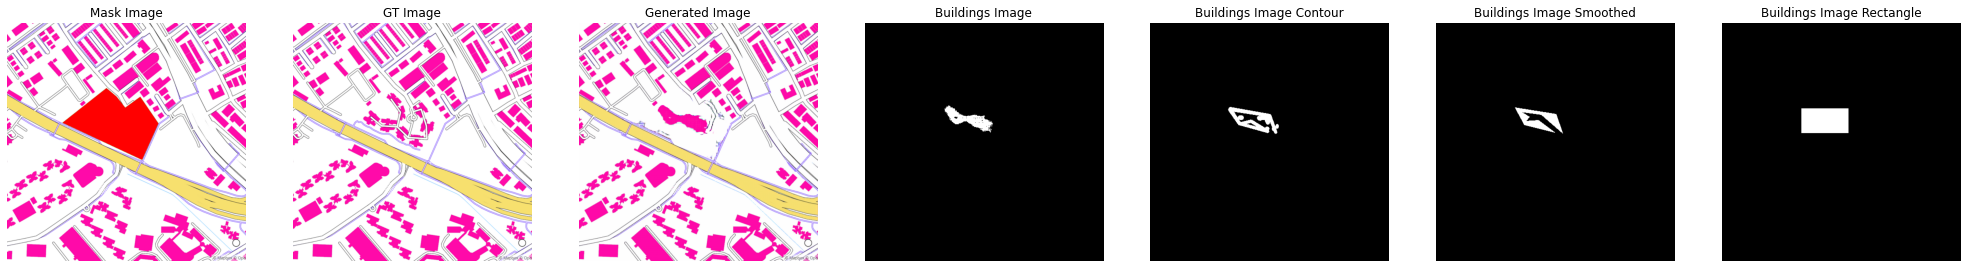

Image: 1484.png, GPR: 3.0, Simplified GPR: 3.0, Storeys:17,  Site area: 10097.1, Building pixels: 1244, Mask pixels: 7571, Generated GPR: 2.793290186236957


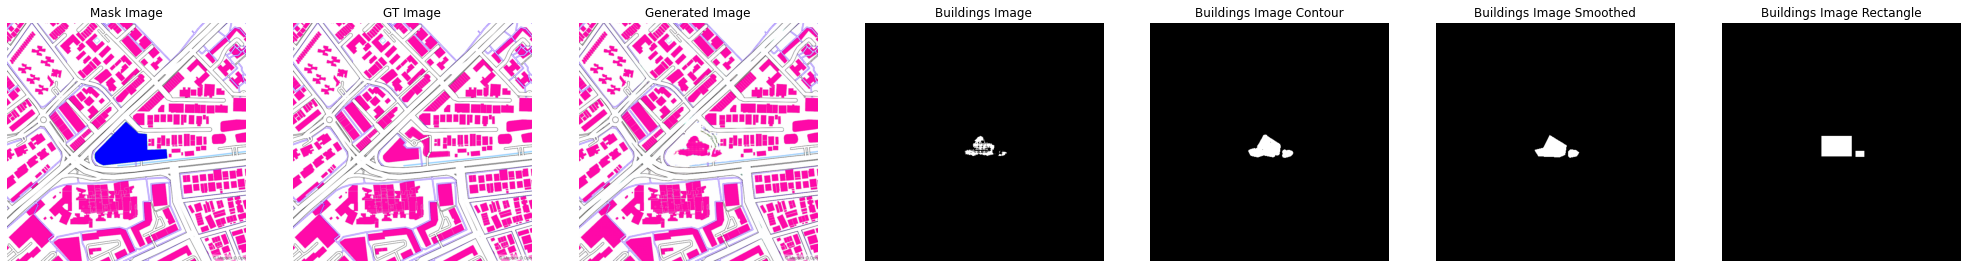

Image: 1602.png, GPR: 3.0, Simplified GPR: 3.0, Storeys:17,  Site area: 13564.8, Building pixels: 1756, Mask pixels: 9875, Generated GPR: 3.022987341772151


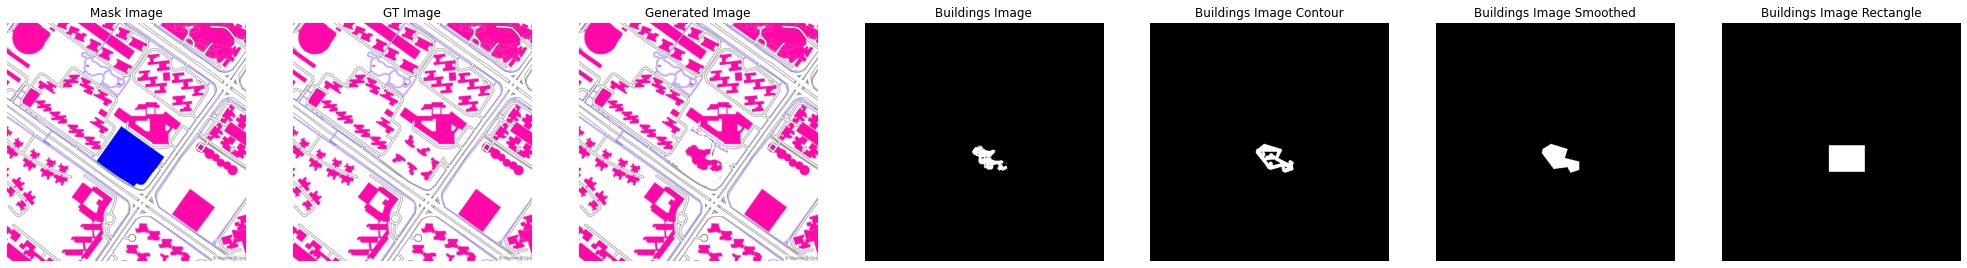

Image: 1655.png, GPR: 2.1, Simplified GPR: 2.1, Storeys:18,  Site area: 27418.2, Building pixels: 3175, Mask pixels: 21711, Generated GPR: 2.6323062042282714


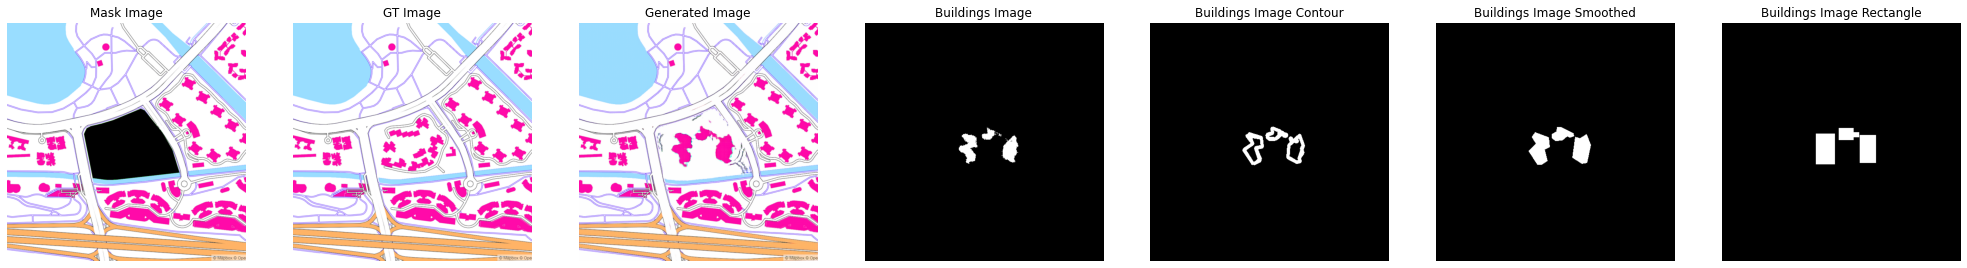

Image: 1670.png, GPR: 2.8, Simplified GPR: 2.8, Storeys:13,  Site area: 17940.2, Building pixels: 1520, Mask pixels: 11713, Generated GPR: 1.6870144284128745


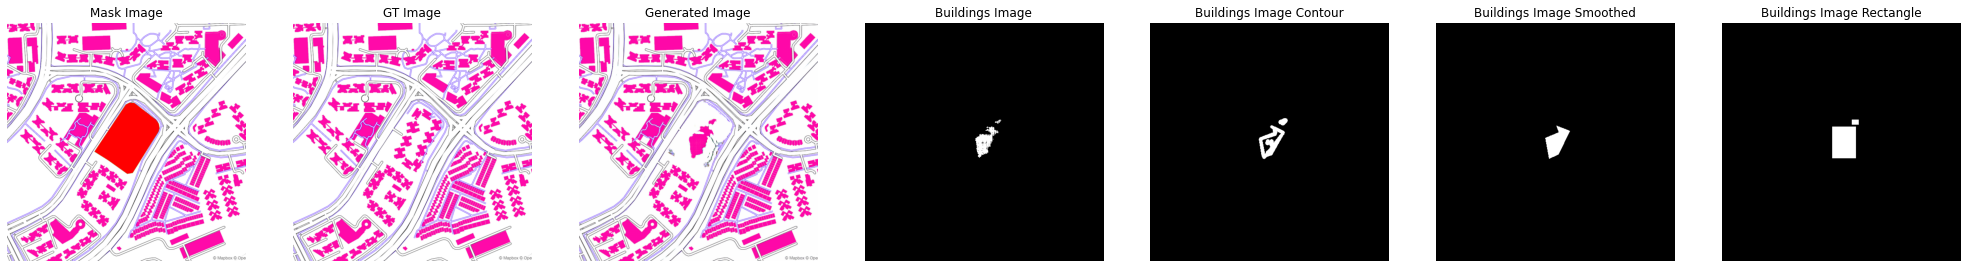

Image: 1796.png, GPR: 2.8, Simplified GPR: 2.8, Storeys:17,  Site area: 13877.2, Building pixels: 1192, Mask pixels: 9260, Generated GPR: 2.1883369330453566


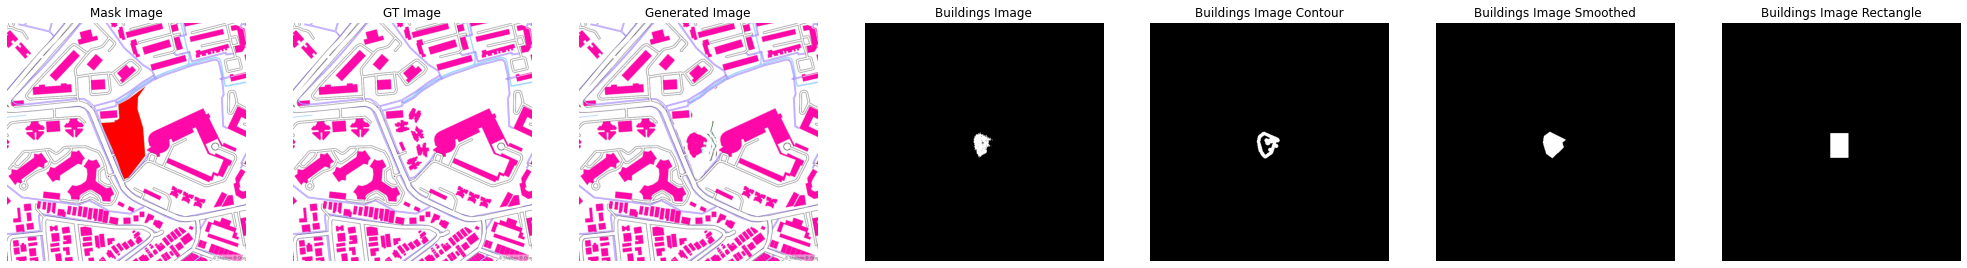

Image: 1811.png, GPR: 1.4, Simplified GPR: 1.4, Storeys:5,  Site area: 7255.7, Building pixels: 2095, Mask pixels: 5237, Generated GPR: 2.0001909490166128


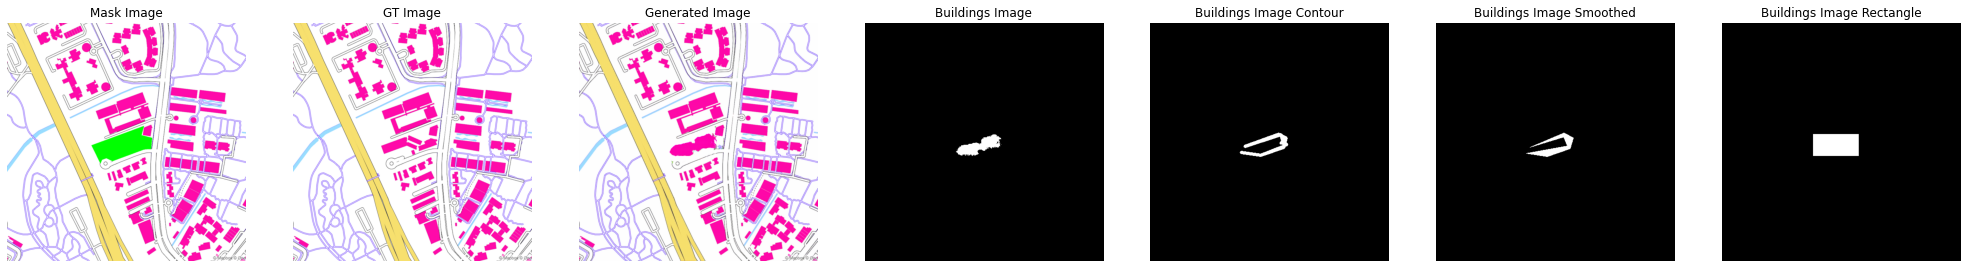

Image: 1876.png, GPR: 2.1, Simplified GPR: 2.1, Storeys:19,  Site area: 10502.8, Building pixels: 1474, Mask pixels: 8220, Generated GPR: 3.4070559610705593


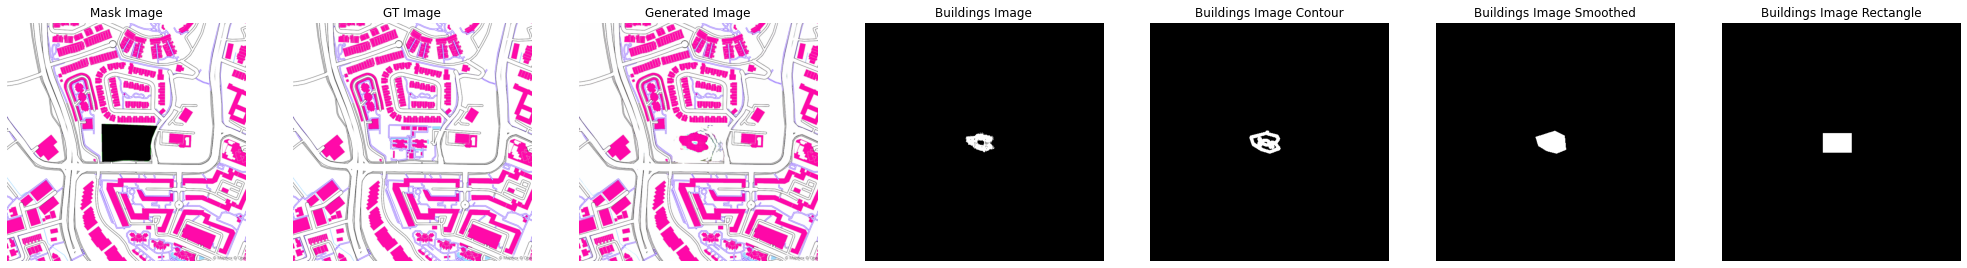

Image: 191.png, GPR: 3.5, Simplified GPR: 3.0, Storeys:18,  Site area: 13000.3, Building pixels: 2180, Mask pixels: 9133, Generated GPR: 4.29650717179459


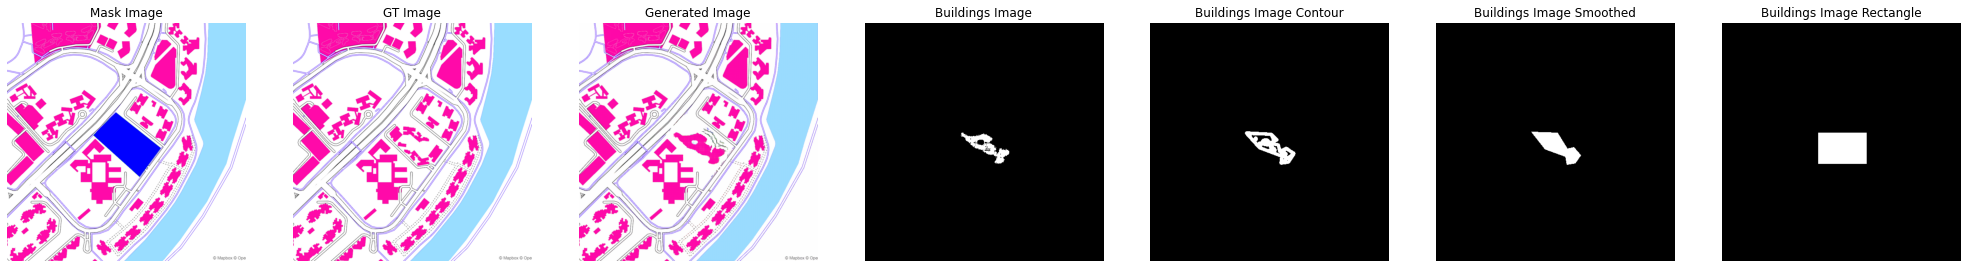

Image: 2000.png, GPR: 3.0, Simplified GPR: 3.0, Storeys:17,  Site area: 13241.8, Building pixels: 2103, Mask pixels: 9581, Generated GPR: 3.7314476568207913


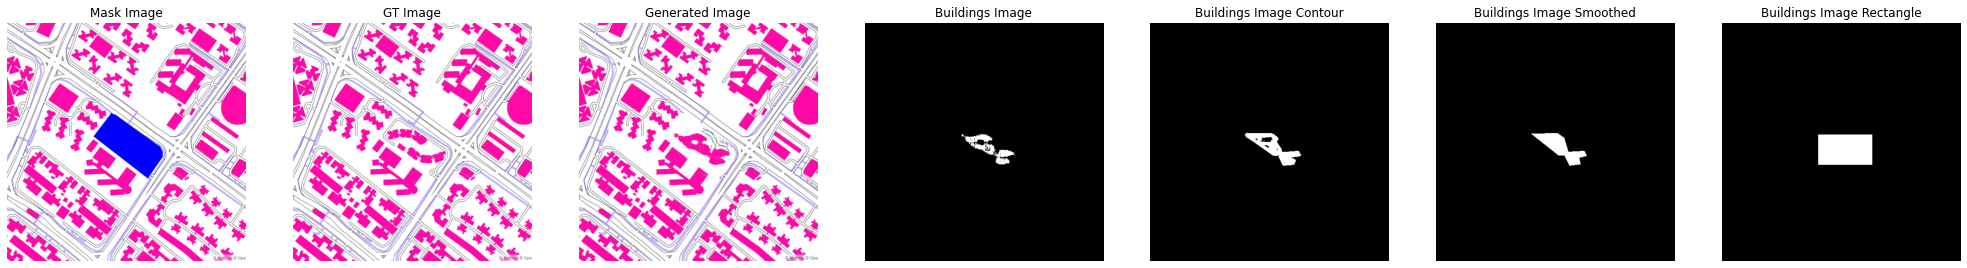

Image: 434.png, GPR: 2.1, Simplified GPR: 2.1, Storeys:16,  Site area: 39401.6, Building pixels: 3629, Mask pixels: 28557, Generated GPR: 2.0332667997338656


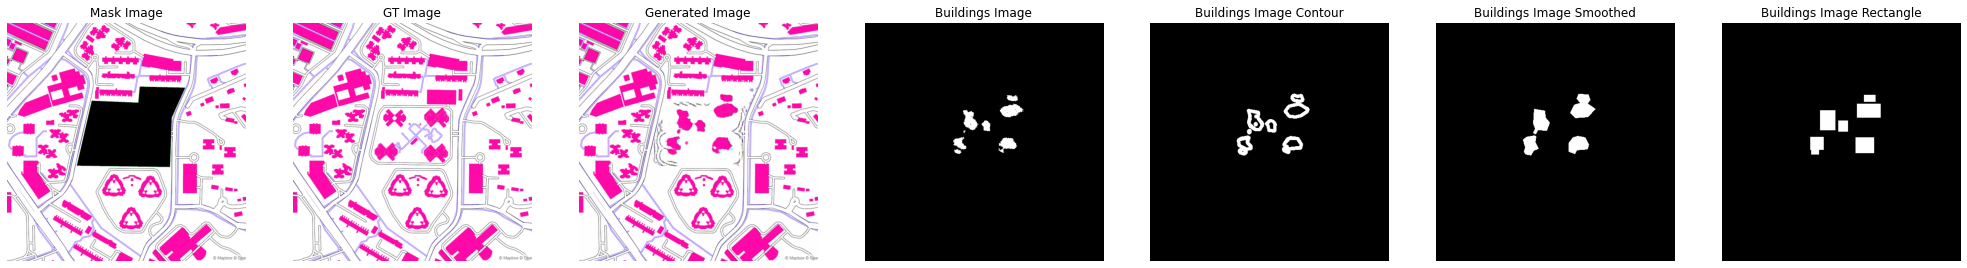

Image: 489.png, GPR: 2.1, Simplified GPR: 2.1, Storeys:15,  Site area: 28692.65, Building pixels: 2616, Mask pixels: 20400, Generated GPR: 1.923529411764706


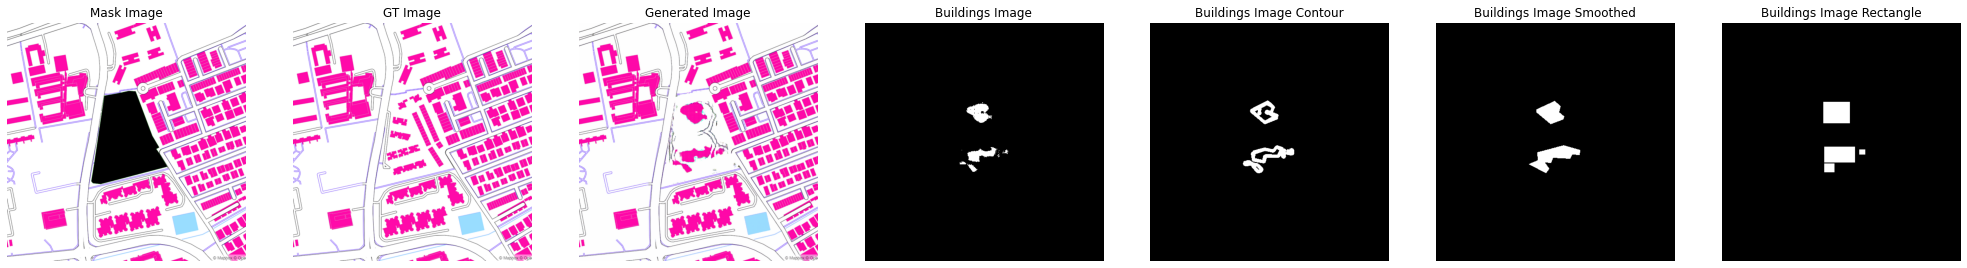

Image: 491.png, GPR: 3.0, Simplified GPR: 3.0, Storeys:16,  Site area: 18747.8, Building pixels: 1892, Mask pixels: 12952, Generated GPR: 2.3372452130945027


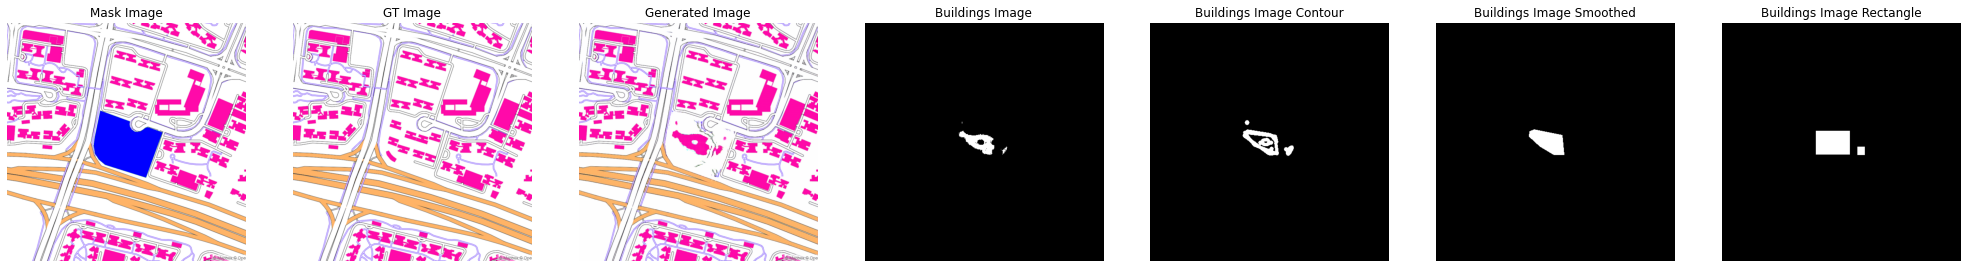

Image: 568.png, GPR: 3.4, Simplified GPR: 3.0, Storeys:19,  Site area: 14344.0, Building pixels: 1877, Mask pixels: 10424, Generated GPR: 3.42123944742901


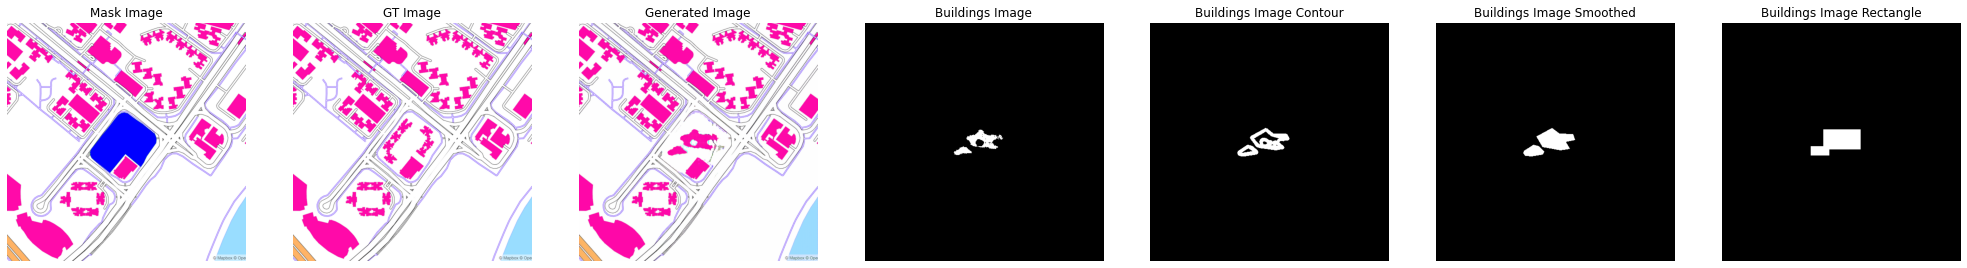

Accuracies:[0.09988450110649702, 0.37392069192992744, 0.5502058168567383, 1.5758054327226785, 0.2614195361911455, 0.3477640565066891, 0.27250722192284227, 0.06890327125434774, 0.007662447257383705, 0.2534791448706054, 0.39749484699540194, 0.21845109534094403, 0.42870782072615204, 0.62240760050979, 0.22757347765559718, 0.24381588560693043, 0.03177771441244499, 0.08403361344537817, 0.22091826230183242, 0.0062468963026500865] 
Square error:[0.019554750580135855, 0.873854274083473, 2.373375296679446, 6.356896670203669, 0.6150615651215425, 0.2370420844360558, 0.5821998582408248, 0.04272894710595201, 0.0005284178817496836, 0.28334989505991015, 1.23873688256112, 0.3741317074763604, 0.36022917528146237, 1.7083952853700832, 0.6344236747202168, 0.535015674668626, 0.004453320017760013, 0.03114186851211074, 0.4392439075661511, 0.000451114127089692] 
Absolute error:[0.13983830154909582, 0.9348017298248186, 1.540576287198867, 2.521288692356286, 0.7842586085734364, 0.48686967910936474, 0.763020221383

In [118]:

directory_path = os.getcwd()
parent_directory_path = os.path.dirname(directory_path)
csv_path = os.path.join(parent_directory_path, 'Model\\condo_data_new_FINAL_test.csv')
gt_masked_image_path = os.path.join(parent_directory_path, 'Model\\rd\\test')
generated_image_path = os.path.join(parent_directory_path, 'Model\\rd\\final_road_output_1') 

# Read the CSV file
data = pd.read_csv(csv_path)

# Function to extract the numeric part of the filename
def extract_numeric_part(filename):
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part) if numeric_part else None

def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

# def find_max_building_storeys(gpr):
#     max_building_storeys= 0
#     if gpr >= 0 and gpr < 1.4:
#         max_building_storeys = 5
#     elif gpr >= 1.4 and gpr < 1.6:
#         max_building_storeys = 12
#     elif gpr >= 1.6 and gpr < 2.1:
#         max_building_storeys = 24
#     elif gpr >= 2.1 and gpr < 2.8:
#         max_building_storeys = 36
#     elif gpr >= 2.8:
#         max_building_storeys = 48 ## by right got no limit
#     return max_building_storeys

def masked_rgb(simp_gpr):
    rgb = [0,0,0]
    if simp_gpr == 1.4:
        rgb = [0,255,0]
    elif simp_gpr == 1.6:
        rgb = [200,130,60]
    elif simp_gpr == 2.1:
        rgb = [0,0,0]
    elif simp_gpr == 2.8:
        rgb = [255,0,0]
    elif simp_gpr == 3.0:
        rgb =[0,0,255]
    return rgb

'''
pink, [255, 10, 169]
brown, [200,130,60]
cyan, [0,255,255]
red, [255,0,0]
black, [0,0,0]
green, [0,255,0]
blue, [0,0,255]
yellow, [255, 255, 0]
'''

# absolute_accuracies = []
# losses =[]
# images =[]
# sanity_ratios =[]

gprs =[]
generated_gprs =[]
sanity_ratios =[]

# Iterate through the images in the generated_image_path
for image_file in os.listdir(generated_image_path):
    if image_file.endswith('.png'):
        image_index = extract_numeric_part(image_file)

        # Construct the path for the corresponding masked image
        gt_mask_image_filename = f"{image_index}.png"
        gt_mask_image = os.path.join(gt_masked_image_path, gt_mask_image_filename)
        open_gt_mask_image = Image.open(gt_mask_image)
        mask_crop_box = (512, 0, 1024, 512) # right side
        mask_image = open_gt_mask_image.crop(mask_crop_box) #gt_mask is concatenated gt and mask
        gt_crop_box = (0, 0, 512, 512) # left side
        gt_image = open_gt_mask_image.crop(gt_crop_box)

        generated_image = os.path.join(generated_image_path, image_file)
        generated_image =  Image.open(generated_image)

        # Check if the image index matches any index in the CSV
        matched_row = data[data['key1'] == image_index]
        if not matched_row.empty:
            # Extract the GPR value for the matched row
            gpr_value = matched_row['GPR'].iloc[0]
            storey = matched_row['storeys'].iloc[0]
            simplified_gpr_value = matched_row['simp_gpr'].iloc[0]
            actual_site_area = matched_row['area'].iloc[0]
            actual_site_area = actual_site_area.replace(',', '')
            actual_site_area = float(actual_site_area[:-4])
            gpr_value = float(gpr_value)
            storey = int(storey)
            mask_array = np.array(mask_image)
            generated_array = np.array(generated_image)

            mask_color = masked_rgb(simplified_gpr_value)
            site_mask = create_binary_mask(mask_array, mask_color)
            site_area_array = generated_array.copy()
            site_area_array[~site_mask] = [255, 255, 255, 255] # making non-masked region white RMB ITS 4 CHANNELS NOW
            site_area_image = Image.fromarray(site_area_array)

            mask_color = [255, 10, 169]
            building_mask = extract_building_regions(site_area_array, mask_color)
            buildings_image = Image.fromarray(building_mask)

            building_pixels = np.sum(building_mask)
            mask_pixels = np.sum(site_mask)
            msq_per_pixel = actual_site_area/mask_pixels
            building_area = msq_per_pixel * building_pixels
            #max_storeys = find_max_building_storeys(gpr_value)
            generated_gpr = building_area*storey/actual_site_area
            gprs.append(gpr_value)
            generated_gprs.append(generated_gpr)

            print(f'Image: {image_file}, GPR: {gpr_value}, Simplified GPR: {simplified_gpr_value}, Storeys:{storey},  Site area: {actual_site_area}, Building pixels: {building_pixels}, Mask pixels: {mask_pixels}, Generated GPR: {generated_gpr}')

            # get contours
            building_mask = building_mask.astype(np.uint8) * 255
            blurred = cv2.GaussianBlur(building_mask, (5, 5), 0) # Apply GaussianBlur to reduce noise and improve edge detection
            edges = cv2.Canny(blurred, 50, 150) #Canny edge detection
            contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            approximated_contours = approx_contours(contours)
            original_approximated_contours = cv2.drawContours(building_mask.copy(), approximated_contours, -1, (255), 10)
            blank_image_for_contour = np.zeros_like(building_mask)
            approximated_contours_image = cv2.drawContours(blank_image_for_contour, approximated_contours, -1, (255), 5)
            
            #get rectangles
            blank_image_for_rectangle = np.zeros_like(building_mask)
            rectangles = [cv2.boundingRect(contour) for contour in approximated_contours]
            non_nested_rectangles = remove_nested_rectangles(rectangles)
            distance_threshold = 10
            merged_rectangles = merge_rectangles(non_nested_rectangles, distance_threshold)
            min_width = 10
            min_height = 10
            for x, y, w, h in merged_rectangles:
                if w >= min_width and h >= min_height:
                    cv2.rectangle(blank_image_for_rectangle, (x, y), (x + w, y + h), (255), -1)  # Fill the rectangle

            # different attempt
            # kernel = np.ones((3,3), np.uint8)
            # dialated_image = cv2.dilate(approximated_contours_image, kernel, iterations=2)
            # contours, _ = cv2.findContours(dialated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # symmetric_contours_image = np.zeros_like(building_mask)
            # cv2.drawContours(symmetric_contour_image, contours, -1, (255), thickness=cv2.FILLED)
            # merged_contours = merge_contours(contours)
            # for contour in merged_contours:
            #     symmetric_contour_image = apply_contour_symmetry(contour, building_mask.shape)
            #     symmetric_contours_image = cv2.bitwise_or(symmetric_contours_image, symmetric_contour_image)
            
            kernel = np.ones((3,3), np.uint8)
            opened_image = cv2.morphologyEx(approximated_contours_image, cv2.MORPH_OPEN, kernel, iterations=1)
            closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel, iterations=1)
            contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_pixels = sum(cv2.contourArea(contour) for contour in contours)
            min_area_threshold = 0.1*contour_pixels
            large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area_threshold] #discard small contours
            smoothed_contours = smooth_contours(large_contours)
            smoothed_image = np.zeros_like(approximated_contours_image)
            cv2.drawContours(smoothed_image, smoothed_contours, -1, (255), thickness=cv2.FILLED)


            plt.figure(figsize=(35, 5))
            plt.subplot(1, 7, 1)
            plt.imshow(mask_image)
            plt.title('Mask Image')
            plt.axis('off')
            plt.subplot(1, 7, 2)
            plt.imshow(gt_image)
            plt.title('GT Image')
            plt.axis('off')
            plt.subplot(1, 7, 3)
            plt.imshow(generated_image)
            plt.title('Generated Image')
            plt.axis('off')
            plt.subplot(1, 7, 4)
            plt.imshow(buildings_image, cmap='gray')
            plt.title('Buildings Image')
            plt.axis('off')
            plt.subplot(1, 7, 5)
            plt.imshow(approximated_contours_image, cmap='gray')
            plt.title('Buildings Image Contour')
            plt.axis('off') 
            plt.subplot(1, 7, 7)
            plt.imshow(blank_image_for_rectangle, cmap='gray')
            plt.title('Buildings Image Rectangle')
            plt.axis('off') 
            plt.subplot(1, 7, 6)
            plt.imshow(smoothed_image, cmap='gray')
            plt.title('Buildings Image Smoothed')
            plt.axis('off') 
            plt.show()

total_data = len(gprs)
accuracies = []
absolute_error =[]
square_error =[]
for tar_gpr, gen_gpr in zip(gprs, generated_gprs):
    accuracies.append(abs((tar_gpr-gen_gpr)/tar_gpr))
    absolute_error.append(abs(tar_gpr-gen_gpr))
    square_error.append((tar_gpr-gen_gpr)**2)
accuracy = sum(accuracies)/total_data
mean_abs_error = sum(absolute_error)/total_data
root_squared_error = math.sqrt(sum(square_error)/total_data)
print(f"Accuracies:{accuracies} \nSquare error:{square_error} \nAbsolute error:{absolute_error} ")
print(f"\nAccuracy:{accuracy} MAE:{mean_abs_error} RMSE:{root_squared_error}")